## Capítulo 8 - Seleção de Atributos

Usamos seleção de atributos (feature selection) para selecionar aqueles que sejam úteis ao modelo. Atributos irrelevantes podem causar um efeito negativo em um modelo. Atributos correlacionados podem deixar os coeficientes de um regressão (ou a importância dos atributos em modelos de árvore) instáveis ou difíceis de interpretar.

Além dissso, o tempo para treinamento dos dados em geral é uma função do número de colunas(às vezes, poderá ser pior que função linear). Se conseguir ser conciso e preciso com suas colunas, será possível obter um modelo melhor em menos tempo. 

In [1]:
# Importar as bibliotecas do capítulo 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Caminho em Pasta
path = "datasets/titanic/titanic3.xls"
df = pd.read_excel(path)
orig_df = df

### Colunas colineares

Podemos usar a função 'correlated_columns' definida antes, ou executar o código a seguir para encontrar colunas que tenham um coeficiente de correlação maior ou igual a 0,95:

In [3]:
agg = (
    df.groupby("cabin")
    .agg("min,max,mean,sum".split(","))
    .reset_index()
)

agg.columns = [ 
    "_".join(c).strip("_")
    for c in agg.columns.values
]
agg_df = df.merge(agg, on="cabin")

/tmp/ipykernel_7619/3089466328.py:2: FutureWarning: ['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("cabin")


In [4]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [5]:
limit = 0.95
corr = agg_df.corr()
mask = np.triu(
    np.ones(corr.shape), k=1
).astype(bool)
corr_no_diag = corr.where(mask)
coll = [
    c
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)
]

In [6]:
coll 

['pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'body_min',
 'body_max',
 'body_mean',
 'body_sum']

O visualizador Rank2 do Yellowbrick, mostrado anteriormente, gerará um heatmap (mapa de calor) com as correlações.

O pacote 'rfpimp (https://oreil.ly/MsnXc)'tem um recurso de visualização de 'multicolinearidade'. A função 'plot_depedence_heatmap' faz o treinamento de uma floresta aleatória (random forest) para cada coluna numérica a partir das outras colunas em um conjunto de dados de treinamento. O valor da dependẽncia é a pontuação R2 das estimativas OOB (Out-Of-Bag) para a predição dessa coluna.

A forma sugerida de usar esse gráfico pe encontrar valores próximos de 1. O rótulo no eixo X é o atributo que faz a predição do rótulo no eixo Y. Se um atributo faz a predição de outro, podemos remover o atributo previsto (o atributo no eixo Y). Em nosso exemplo, fare faz a predição de pclass, sibsp, parch e embarked_Q. Podemos manter fare e remover os demais atributos, obtendo um desempenho semelhante:

In [7]:
#!pip install rfpimp

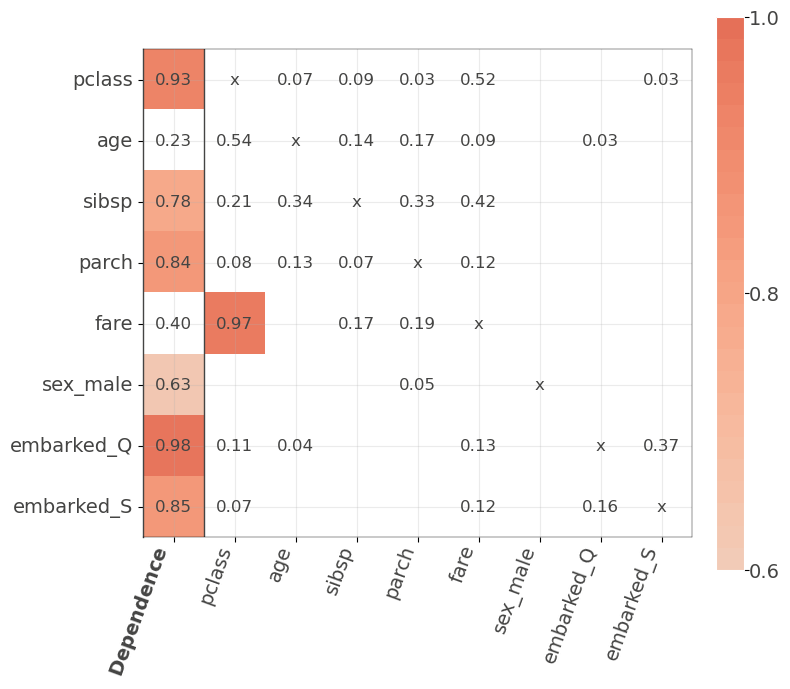

In [8]:
import rfpimp
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
)
fig = plt.gcf()
fig.savefig(
    "images/mlpr_0801.png",
    dpi=300,
    bbox_inches="tight",
)

In [9]:
# Código que mostra que teremos uma pontuação parecida se removermos essas colunas:
cols_to_remove = [
    "pclass",
    "sibsp",
    "parch",
    "embarked_Q",
]

In [10]:
rf3 = RandomForestClassifier(random_state=42)
rf3.fit(
    X_train[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_train,
)

RandomForestClassifier(random_state=42)

In [11]:
rf3.score(
    X_test[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_test,
)

0.7582697201017812

In [12]:
rf4 = RandomForestClassifier(random_state=42)
rf4.fit(X_train, y_train)
rf4.score(X_test, y_test)

0.7938931297709924

### Regressão Lasso

Se usar a regressão lasso, poderá definir um parâmetro alpha que atuará como um parâmetro de regularização. À medida que seu valor aumentar, menor peso será dado aos atributos que são menos importantes. 

No código a seguir, será usado o modelo LassoLarsCV para iterar por diversos valores de alpha e monitorar os coeficientes dos atributos.

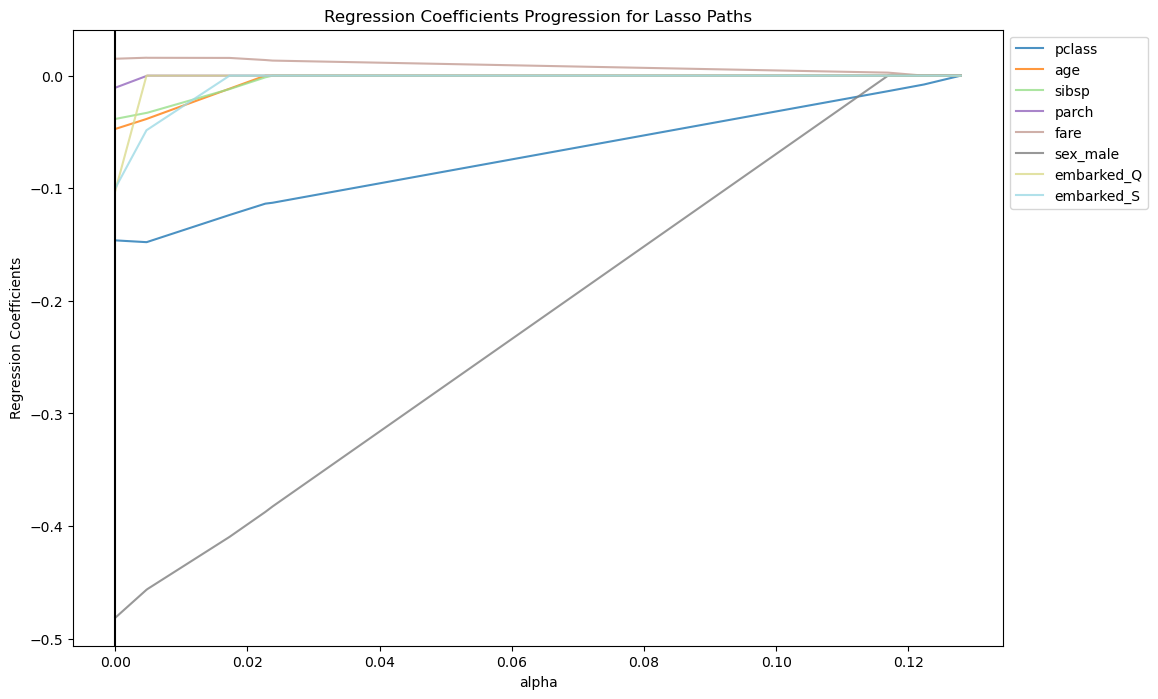

In [13]:
from sklearn import linear_model
model = linear_model.LassoLarsCV(
    cv=10, max_n_alphas=10
).fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(12, 8))
cm = iter(
    plt.get_cmap("tab20")(
        np.linspace(0, 1, X.shape[1])
    )
)

for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(
        model.alphas_,
        model.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X.columns[i],
    )

ax.axvline(
    model.alpha_,
    linestyle="-",
    c="k",
    label="alphaCV",
)

plt.ylabel("Regression Coefficients")
ax.legend(X.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title(
    "Regression Coefficients Progression for Lasso Paths"
)

ax.legend(X.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title(
    "Regression Coefficients Progression for Lasso Paths"
)

fig.savefig(
    "images/mlpr_0802.png",
    dpi=300,
    bbox_inches="tight",
)

### Eliminação recursiva de atributos

A eliminação recursiva de atributos removerá os atributos mais fracos, e então fará a adequação de um modelo. Fazemos isso passando um modelo do scikit-learn com um atributo '.coef_' ou '.feature_importances_':

RFECV(ax=<AxesSubplot:>, cv=5, estimator=RandomForestClassifier())

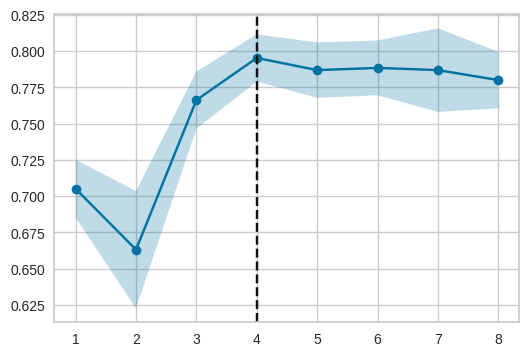

In [14]:
from yellowbrick.features import RFECV
fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100
    ),
    cv=5,
)
rfe.fit(X, y)

In [15]:
rfe.rfe_estimator_.ranking_

array([1, 1, 2, 3, 1, 1, 5, 4])

In [16]:
rfe.rfe_estimator_.n_features_

4

In [17]:
rfe.rfe_estimator_.support_

array([ True,  True, False, False,  True,  True, False, False])

In [18]:
rfe.poof()
fig.savefig(
        "images/mlpr_0803.png", dpi=300
)

Será usada a eliminação recursiva de atributos para encontrar os dez atributos mais importantes. (Nesse conjunto de dados agregados, vimos que há vazamento da coluna de sobrevivência!)

In [19]:
from sklearn.feature_selection import RFE
model = ensemble.RandomForestClassifier(
    n_estimators=100
)
rfe = RFE(model, step = 4)
rfe.fit(X, y)
X.columns[rfe.support_]

Index(['pclass', 'age', 'fare', 'sex_male'], dtype='object')

### Informações mútuas

O sklearn disponibiliza testes não paramétricos que usarão os k vizinhos mais próximos (k-nearest neighbor) para determinar as informações mútuas entre os atributos e o objetivo. As informações mútuas quantificam o volume de informações obtidas observando outra variável. O valor pode ser maior ou igual a zero. Se o valor for igual a zero, é sinal que não há nenhuma relação entre os atributos e o alvo. Esse número não é limitado e representa o número de porções compartilhadas entre eles:

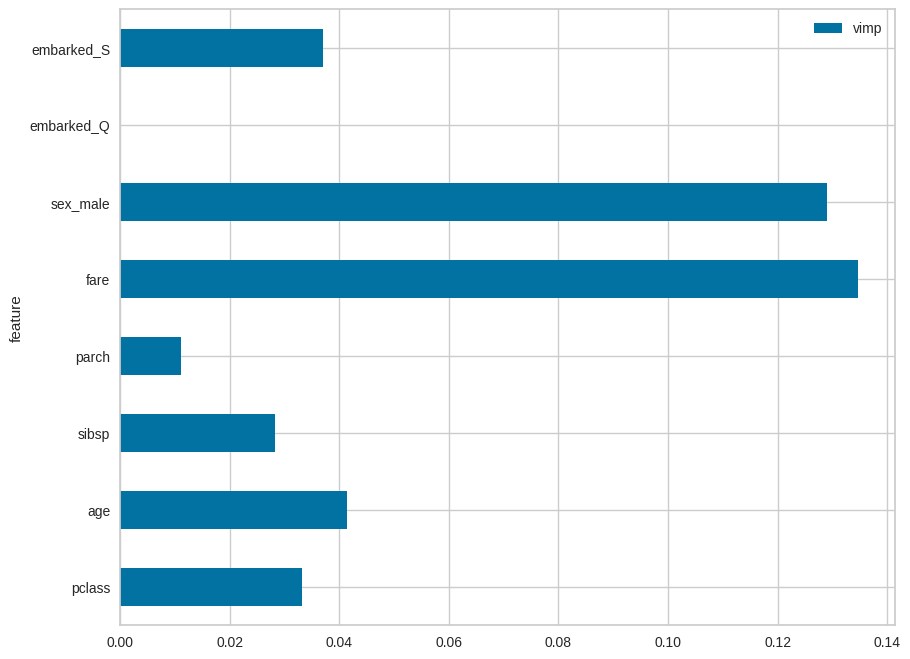

In [20]:
from sklearn import feature_selection

mic = feature_selection.mutual_info_classif(X, y)

fig, ax = plt.subplots(figsize=(10, 8))
(
    pd.DataFrame(
        {"feature": X.columns, "vimp": mic}
    )
    .set_index("feature")
    .plot.barh(ax=ax)
)

fig.savefig("images/mlpr_0804.png")

In [ ]:
importância dos atributos

A maioria dis modelos baseados em árvore oferece acesso a um atributo '.feature_importances_' após o treinamento. Uma importância maior em geral implica que haverá um erro maior se o 